# Part B: Model Refinement

Systematically tune the hyperparameters of all clustering algorithms from Part A, analyze the impact of tuning, understand parameter choices, identify the overall best-performing model after optimization, and save the necessary results for an interactive Streamlit dashboard.

1. Initial Setup & load data from part A

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import joblib
import random
import os
import time # To time tuning processes
import warnings
from sklearn.model_selection import ParameterGrid

warnings.filterwarnings('ignore') # Suppress routine warnings

# Clustering Algorithms
from sklearn.cluster import (
    KMeans,
    MeanShift,
    estimate_bandwidth,
    AgglomerativeClustering,
    Birch, 
    DBSCAN
)
from sklearn.mixture import GaussianMixture
try:
    import hdbscan
    hdbscan_available = True
except ImportError:
    print("HDBSCAN library not found. Install if needed: pip install hdbscan")
    hdbscan_available = False

# Evaluation Metrics
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

# --- Configuration ---
# Directory where Part A outputs were saved
INPUT_DIR_PART_B = 'part_b_inputs'
# Directory to save Part B outputs (for Streamlit)
OUTPUT_DIR_STREAMLIT = 'streamlit_app_data'
os.makedirs(OUTPUT_DIR_STREAMLIT, exist_ok=True)

# Primary metric for selecting best parameters (usually Silhouette)
PRIMARY_METRIC = 'Silhouette'
# Set higher_is_better based on the primary metric
HIGHER_IS_BETTER = True if PRIMARY_METRIC == 'Silhouette' or PRIMARY_METRIC == 'Calinski-Harabasz' else False

print(f"Input Directory: {INPUT_DIR_PART_B}")
print(f"Output Directory for Streamlit: {OUTPUT_DIR_STREAMLIT}")
print(f"Primary metric for optimization: {PRIMARY_METRIC} (Higher is better: {HIGHER_IS_BETTER})")

# --- Load Data and Objects ---
print("\n--- Loading Data for Part B ---")
try:
    # Load PCA Data
    pca_2d_filepath = os.path.join(INPUT_DIR_PART_B, 'pca_2d_data.csv')
    pca_3d_filepath = os.path.join(INPUT_DIR_PART_B, 'pca_3d_data.csv')
    df_pca_2d = pd.read_csv(pca_2d_filepath)
    df_pca_3d = pd.read_csv(pca_3d_filepath)
    X_pca_2d = df_pca_2d.values
    X_pca_3d = df_pca_3d.values
    print(f"Loaded 2D PCA data: {X_pca_2d.shape}")
    print(f"Loaded 3D PCA data: {X_pca_3d.shape}")

    # Load PCA Objects
    pca_2d_obj_filepath = os.path.join(INPUT_DIR_PART_B, 'pca_2d_object.joblib')
    pca_3d_obj_filepath = os.path.join(INPUT_DIR_PART_B, 'pca_3d_object.joblib')
    pca_2d = joblib.load(pca_2d_obj_filepath)
    pca_3d = joblib.load(pca_3d_obj_filepath)
    print("Loaded PCA objects.")

    # Load Part A Results Summary
    part_a_results_filepath = os.path.join(INPUT_DIR_PART_B, 'part_a_results_summary.csv')
    part_a_results_df = pd.read_csv(part_a_results_filepath)
    print("Loaded Part A results summary.")

    # Load Part A Initial Parameters (Optional Reference)
    part_a_params_filepath = os.path.join(INPUT_DIR_PART_B, 'part_a_initial_params.joblib')
    part_a_initial_params = joblib.load(part_a_params_filepath)
    print("Loaded Part A initial parameters reference.")

except FileNotFoundError as e:
    print(f"\nError loading files: {e}")
    print("Please ensure all necessary files from Part A notebook were saved correctly in the input directory.")
    # Optionally exit or handle the error appropriately
    raise # Re-raise the exception to stop execution if files are missing

# --- Data Selection for Tuning ---
# Based on Part A analysis, 2D PCA data performed best overall.
# We will focus tuning on the 2D data.
X_tuning = X_pca_2d
tuning_dimensionality_label = "2D"
print(f"\n--- Focusing Tuning on {tuning_dimensionality_label} PCA Data ---")

Input Directory: part_b_inputs
Output Directory for Streamlit: streamlit_app_data
Primary metric for optimization: Silhouette (Higher is better: True)

--- Loading Data for Part B ---
Loaded 2D PCA data: (18135, 2)
Loaded 3D PCA data: (18135, 3)
Loaded PCA objects.
Loaded Part A results summary.
Loaded Part A initial parameters reference.

--- Focusing Tuning on 2D PCA Data ---


In [2]:
# Import necessary libraries for clustering and evaluation
import numpy as np
import pandas as pd # Assuming df_scaled comes from a pandas DataFrame initially
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns # For potentially better visualizations
from sklearn.cluster import (
    KMeans,
    MeanShift,
    estimate_bandwidth,
    AgglomerativeClustering,
    Birch,
    DBSCAN,
)
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.preprocessing import StandardScaler # Keep handy if needed later
from sklearn.decomposition import PCA # Already imported, but good practice
import warnings
# Install hdbscan if you haven't: pip install hdbscan
try:
    import hdbscan
except ImportError:
    print("HDBSCAN library not found. Please install it using: pip install hdbscan")
    # Optionally, decide how to proceed: skip HDBSCAN, exit, etc.
    # For now, we'll allow the script to continue but HDBSCAN will fail later if not installed.
    pass



In [3]:
print("\n--- Starting Part A: Identifying and Selecting Promising Models ---")

print("\n--- Step 6: Defining Evaluation Function ---")

def evaluate_clustering(X, labels, algorithm_name, data_dimensionality):
    """
    Calculates and prints key clustering evaluation metrics.

    Args:
        X (np.ndarray): The data used for clustering (e.g., PCA results).
        labels (np.ndarray): The cluster labels assigned by the algorithm.
        algorithm_name (str): Name of the clustering algorithm used.
        data_dimensionality (str): Description of the data (e.g., '2D PCA', '3D PCA').

    Returns:
        dict: A dictionary containing the calculated scores. Returns None if metrics
              cannot be calculated (e.g., < 2 clusters or noise points only).
    """
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels[unique_labels != -1]) # Exclude noise label (-1) if present

    print(f"\n--- Evaluation for {algorithm_name} on {data_dimensionality} Data ---")
    print(f"Number of clusters found: {n_clusters}")
    if -1 in unique_labels:
        n_noise = np.sum(labels == -1)
        print(f"Number of noise points: {n_noise} ({(n_noise / len(labels)):.2%})")

    results = {
        'Algorithm': algorithm_name,
        'Dimensionality': data_dimensionality,
        'Num_Clusters': n_clusters,
        'Silhouette': None,
        'Davies-Bouldin': None,
        'Calinski-Harabasz': None
    }

    # Metrics require at least 2 clusters and data points assigned to clusters
    # Filter out noise points for metric calculation if they exist
    if n_clusters >= 2:
        if -1 in unique_labels:
            mask = labels != -1
            X_filtered = X[mask]
            labels_filtered = labels[mask]
            # Ensure there are still enough points after filtering
            if len(np.unique(labels_filtered)) < 2 or X_filtered.shape[0] < 2:
                 print("Not enough clustered points to calculate metrics after removing noise.")
                 return results # Return results with None values for metrics
        else:
            X_filtered = X
            labels_filtered = labels

        # Ensure we still have enough points and clusters after filtering
        if len(np.unique(labels_filtered)) >= 2 and X_filtered.shape[0] >= 2:
            try:
                silhouette = silhouette_score(X_filtered, labels_filtered)
                davies_bouldin = davies_bouldin_score(X_filtered, labels_filtered)
                calinski_harabasz = calinski_harabasz_score(X_filtered, labels_filtered)

                results['Silhouette'] = silhouette
                results['Davies-Bouldin'] = davies_bouldin
                results['Calinski-Harabasz'] = calinski_harabasz

                print(f"Silhouette Score: {silhouette:.4f} (Higher is better, range [-1, 1])")
                print(f"Davies-Bouldin Index: {davies_bouldin:.4f} (Lower is better, >= 0)")
                print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f} (Higher is better)")
            except Exception as e:
                 print(f"Could not calculate metrics: {e}")
                 # Store None in results if calculation fails
        else:
             print("Not enough clusters or data points remaining after filtering noise to calculate metrics.")

    else:
        print("Cannot calculate metrics: Need at least 2 clusters.")

    return results


--- Starting Part A: Identifying and Selecting Promising Models ---

--- Step 6: Defining Evaluation Function ---


In [4]:
print("\n--- Step 7: Defining Visualization Functions ---")

def plot_clusters_2d(X, labels, pca_obj, algorithm_name, title_suffix=""):
    """Plots 2D clustering results."""
    unique_labels = sorted(np.unique(labels))
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels))) # Use viridis colormap

    plt.figure(figsize=(10, 7))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Plot noise points distinctly (grey and smaller)
            col = [0.5, 0.5, 0.5, 0.6] # Grey color with some transparency
            markersize = 4
            label = 'Noise'
        else:
            markersize = 6
            label = f'Cluster {k}'

        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=markersize, label=label, alpha=0.7)

    plt.xlabel(f"Principal Component 1 ({pca_obj.explained_variance_ratio_[0]:.2%} Variance)")
    plt.ylabel(f"Principal Component 2 ({pca_obj.explained_variance_ratio_[1]:.2%} Variance)")
    plt.title(f'Clustering Result ({algorithm_name} on 2D PCA){title_suffix}')
    if len(unique_labels) < 15: # Avoid overly cluttered legends
        plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def plot_clusters_3d(X, labels, pca_obj, algorithm_name, title_suffix=""):
    """Plots 3D clustering results."""
    unique_labels = sorted(np.unique(labels))
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels))) # Consistent colormap

    fig = plt.figure(figsize=(11, 8))
    ax = fig.add_subplot(111, projection='3d')

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0.5, 0.5, 0.5, 0.6] # Grey for noise
            markersize = 10 # Adjust size for 3D visibility
            label = 'Noise'
            alpha = 0.5
        else:
            markersize = 15 # Adjust size for 3D visibility
            label = f'Cluster {k}'
            alpha = 0.7

        class_member_mask = (labels == k)
        xyz = X[class_member_mask]
        ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=markersize, c=[col[:3]], label=label, alpha=alpha, edgecolor='k', linewidth=0.5) # Use only RGB for 'c'

    ax.set_xlabel(f"PC 1 ({pca_obj.explained_variance_ratio_[0]:.2%} Var)")
    ax.set_ylabel(f"PC 2 ({pca_obj.explained_variance_ratio_[1]:.2%} Var)")
    ax.set_zlabel(f"PC 3 ({pca_obj.explained_variance_ratio_[2]:.2%} Var)")
    ax.set_title(f'Clustering Result ({algorithm_name} on 3D PCA){title_suffix}')

    # Improve layout and viewpoint
    plt.tight_layout()
    ax.view_init(elev=20., azim=-65) # Adjust viewing angle if necessary

    if len(unique_labels) < 15:
        ax.legend(loc='best')
    plt.show()



--- Step 7: Defining Visualization Functions ---


In [5]:
# --- Step 8: Apply and Evaluate Clustering Algorithms ---
print("\n--- Step 8: Applying and Evaluating Clustering Algorithms ---")

# Store results for comparison later
all_results = []

# Function to apply, evaluate, and plot for a given algorithm and data
def run_clustering_analysis(algorithm, name, X_2d, X_3d, pca_2d_obj, pca_3d_obj, **kwargs):
    """Fits algorithm, evaluates, plots, and stores results for 2D and 3D PCA data."""
    print(f"\n{'='*15} Analyzing {name} {'='*15}")

    # --- Analysis on 2D PCA Data ---
    print(f"\n--- {name} on 2D PCA Data ---")
    try:
        model_2d = algorithm(**kwargs) # Instantiate model with specific params
        # Special handling for models that don't have a predict method (like Agglomerative)
        if hasattr(model_2d, 'fit_predict'):
            labels_2d = model_2d.fit_predict(X_2d)
        elif hasattr(model_2d, 'fit') and hasattr(model_2d, 'labels_'):
             model_2d.fit(X_2d)
             labels_2d = model_2d.labels_
        else:
            print(f"Model {name} fitting/label extraction needs specific handling.")
            labels_2d = None # Skip if unsure how to get labels

        if labels_2d is not None:
            results_2d = evaluate_clustering(X_2d, labels_2d, name, '2D PCA')
            if results_2d: all_results.append(results_2d)
            plot_clusters_2d(X_2d, labels_2d, pca_2d_obj, name)
        else:
            print("Skipping 2D evaluation and plotting due to label extraction issue.")

    except Exception as e:
        print(f"Error running {name} on 2D data: {e}")

    # --- Analysis on 3D PCA Data ---
    print(f"\n--- {name} on 3D PCA Data ---")
    try:
        # Re-instantiate for 3D to ensure fresh fit, unless model state isn't an issue
        # For most sklearn models, it's safer to re-instantiate or be sure fit() resets state.
        model_3d = algorithm(**kwargs)
        if hasattr(model_3d, 'fit_predict'):
            labels_3d = model_3d.fit_predict(X_3d)
        elif hasattr(model_3d, 'fit') and hasattr(model_3d, 'labels_'):
             model_3d.fit(X_3d)
             labels_3d = model_3d.labels_
        else:
            print(f"Model {name} fitting/label extraction needs specific handling.")
            labels_3d = None # Skip if unsure how to get labels

        if labels_3d is not None:
            results_3d = evaluate_clustering(X_3d, labels_3d, name, '3D PCA')
            if results_3d: all_results.append(results_3d)
            plot_clusters_3d(X_3d, labels_3d, pca_3d_obj, name)
        else:
            print("Skipping 3D evaluation and plotting due to label extraction issue.")

    except Exception as e:
        print(f"Error running {name} on 3D data: {e}")


--- Step 8: Applying and Evaluating Clustering Algorithms ---


**Tuning Loop Implementation**

function to perfom manual grid search, evaluate and to store the result

In [6]:
import random # Add this import at the top of the cell with imports

def tune_clustering_model(model_class, param_grid, X, model_name, dimensionality_label,
                          grid_size_threshold=60, # Threshold to switch to random sampling
                          n_iter_random=50,       # Number of iterations for random sampling
                          **kwargs):               # Existing fixed arguments
    """
    Performs manual grid search or randomized sampling for a clustering algorithm.

    Args:
        model_class: The class of the clustering algorithm (e.g., KMeans).
        param_grid (dict): Dictionary with parameter names as keys and lists of values to test.
        X (np.ndarray): The data to cluster.
        model_name (str): Name of the model for reporting.
        dimensionality_label (str): Label for the data dimensionality (e.g., "2D").
        grid_size_threshold (int): If total combinations exceed this, use random sampling.
        n_iter_random (int): Number of parameter settings to sample in randomized search.
        **kwargs: Additional fixed arguments for the model initializer (e.g., random_state).

    Returns:
        tuple: (best_params, best_score, best_labels, results_df)
               - best_params (dict): Parameters that yielded the best score.
               - best_score (float): The best score achieved based on PRIMARY_METRIC.
               - best_labels (np.ndarray): Cluster labels from the best run.
               - results_df (pd.DataFrame): DataFrame containing results for all tested combinations.
    """

    print(f"\n--- Tuning {model_name} ({dimensionality_label} PCA) ---")
    start_time = time.time()

    # Generate all parameter combinations
    from sklearn.model_selection import ParameterGrid
    full_grid = list(ParameterGrid(param_grid))
    n_total_combinations = len(full_grid)


    # Decide whether to use full grid or random sampling
    if n_total_combinations > grid_size_threshold:
        search_type = "Randomized Sampling"
        # Ensure n_iter is not more than the total combinations
        n_iter_actual = min(n_iter_random, n_total_combinations)
        print(f"Total combinations ({n_total_combinations}) > threshold ({grid_size_threshold}). Performing randomized search with {n_iter_actual} iterations.")
        # Sample n_iter_actual combinations WITHOUT replacement
        parameter_combinations_to_test = random.sample(full_grid, n_iter_actual)
    else:
        search_type = "Grid Search"
        print(f"Total combinations ({n_total_combinations}) <= threshold ({grid_size_threshold}). Performing full grid search.")
        parameter_combinations_to_test = full_grid # Test all combinations

    n_combinations_tested = len(parameter_combinations_to_test)
    # Initialize tracking variables
    best_score = -np.inf if HIGHER_IS_BETTER else np.inf
    best_params = None
    best_labels = None
    all_run_results = []

    # --- Loop through selected combinations ---
    for i, params in enumerate(parameter_combinations_to_test):
        print(f"  {search_type} - Running combination {i+1}/{n_combinations_tested}: {params}", end='\r') # Overwrite line
        current_run_result = params.copy()
        current_run_result.update({
            'Silhouette': None, 'Davies-Bouldin': None, 'Calinski-Harabasz': None,
            'Num_Clusters': None, 'Error': None
        })

        # --- Special parameter handling INSIDE the loop ---
        model_params = params.copy()
        if model_name == "SpectralClustering": # Handle SpectralClustering conditional params
             if params.get('affinity') == 'rbf':
                 model_params.pop('n_neighbors', None)
             elif params.get('affinity') == 'nearest_neighbors':
                 model_params.pop('gamma', None)
        elif model_name == "AgglomerativeClustering": # Handle Agglomerative linkage constraint
             if params.get('linkage') == 'ward' and params.get('metric') != 'euclidean':
                 # This combo is invalid, skip it (though the grid was pre-filtered in the call)
                 # Alternatively, force metric to euclidean if linkage is ward
                 model_params['metric'] = 'euclidean' # Force it here for safety
        # Add other model-specific parameter cleaning here if needed

        # --- Model fitting and evaluation (same as before) ---
        try:
            # Add n_jobs=-1 specifically for SpectralClustering if relevant
            if model_name == "SpectralClustering":
                # Check if 'n_jobs' is already in fixed kwargs, otherwise add it
                if 'n_jobs' not in kwargs:
                    model_params['n_jobs'] = -1

            # Initialize model with potentially cleaned params and fixed kwargs
            model = model_class(**model_params, **kwargs)

            # Fit and predict/get labels (adjust based on model type)
            if hasattr(model, 'fit_predict'):
                labels = model.fit_predict(X)
            elif hasattr(model, 'fit') and hasattr(model, 'labels_'):
                model.fit(X)
                labels = model.labels_
            elif isinstance(model, GaussianMixture):
                 model.fit(X)
                 labels = model.predict(X)
            # Add HDBSCAN specific fitting if needed (though it has fit_predict)
            elif hdbscan_available and isinstance(model, hdbscan.HDBSCAN):
                labels = model.fit_predict(X)
            else:
                 raise NotImplementedError(f"Label extraction logic missing for {model_name}")


            # Evaluate clustering
            n_clusters = len(np.unique(labels[labels != -1]))
            current_run_result['Num_Clusters'] = n_clusters

            if n_clusters >= 2:
                X_filtered = X[labels != -1]
                labels_filtered = labels[labels != -1]
                if len(np.unique(labels_filtered)) >= 2 and X_filtered.shape[0] >= 2:
                    # Calculate metrics
                    silhouette = silhouette_score(X_filtered, labels_filtered)
                    davies_bouldin = davies_bouldin_score(X_filtered, labels_filtered)
                    calinski_harabasz = calinski_harabasz_score(X_filtered, labels_filtered)

                    current_run_result['Silhouette'] = silhouette
                    current_run_result['Davies-Bouldin'] = davies_bouldin
                    current_run_result['Calinski-Harabasz'] = calinski_harabasz

                    # Check if current score is better than best score
                    current_score = current_run_result[PRIMARY_METRIC]
                    # Handle potential None scores if metric calculation failed unexpectedly
                    if current_score is not None:
                        is_better = (HIGHER_IS_BETTER and current_score > best_score) or \
                                    (not HIGHER_IS_BETTER and current_score < best_score)

                        if is_better:
                            best_score = current_score
                            best_params = params # Store original params from grid
                            # We'll get best_labels during the re-fit later
                else:
                     current_run_result['Error'] = "Filtered data insufficient for metrics"
            else:
                 current_run_result['Error'] = "Less than 2 clusters found"

        except Exception as e:
            current_run_result['Error'] = str(e)

        all_run_results.append(current_run_result)
    # --- End of Loop ---

    print(f"\nFinished tuning {model_name} ({search_type}) in {time.time() - start_time:.2f} seconds.")

    if best_params is None:
        print(f"Warning: No valid clustering solution found for {model_name} during tuning.")
        return None, None, None, pd.DataFrame(all_run_results)

    results_df = pd.DataFrame(all_run_results)
    results_df = results_df.sort_values(by=PRIMARY_METRIC, ascending=(not HIGHER_IS_BETTER), na_position='last') # Handle potential NaNs

    print(f"Best {PRIMARY_METRIC} score found for {model_name}: {best_score:.4f}")
    print(f"Best parameters found: {best_params}")

    # --- Re-fit with best parameters to get final labels ---
    print(f"Re-fitting {model_name} with best parameters to ensure correct labels...")
    final_params_cleaned = best_params.copy() # Clean params again before final fit
    if model_name == "SpectralClustering":
         if final_params_cleaned.get('affinity') == 'rbf': final_params_cleaned.pop('n_neighbors', None)
         elif final_params_cleaned.get('affinity') == 'nearest_neighbors': final_params_cleaned.pop('gamma', None)
    elif model_name == "AgglomerativeClustering":
         if final_params_cleaned.get('linkage') == 'ward': final_params_cleaned['metric'] = 'euclidean'

    try:
        
        final_model = model_class(**final_params_cleaned, **kwargs)
        if hasattr(final_model, 'fit_predict'):
            best_labels = final_model.fit_predict(X)
        elif hasattr(final_model, 'fit') and hasattr(final_model, 'labels_'):
            final_model.fit(X)
            best_labels = final_model.labels_
        elif isinstance(final_model, GaussianMixture):
             final_model.fit(X)
             best_labels = final_model.predict(X)
        elif hdbscan_available and isinstance(final_model, hdbscan.HDBSCAN):
             best_labels = final_model.fit_predict(X)
        else:
            print(f"Warning: Could not re-fit {model_name} reliably.")
            best_labels = None # Set to None if refit fails

    except Exception as e:
        print(f"Error during final re-fit for {model_name}: {e}")
        best_labels = None


    return best_params, best_score, best_labels, results_df

### **Step 1: Hyperparameter Tuning**

this phase focuses on finding the best settings for each model. Each model functions differently, hence we need to identify each model's most important hyperparameters that influence its behaviour.


1. K-Means
2. Agglomerative Clustering
3. BIRCH
4. Gaussian Mixture Model
5. Mean Shift
6. HDBSCAN
7. DBSCAN


Defining parameter grids

In [7]:
# --- Parameter Grids for Tuning ---

param_grids = {
    "KMeans": {
        'n_clusters': list(range(2, 9)), # Test around the expected k=3
        'init': ['k-means++', 'random'],
        'n_init': [10, 20] # Standard practice
    },
    "MeanShift": {
        # Tuning bandwidth is tricky; estimate_bandwidth often preferred.
        # Alternatively, test quantile values if using estimate_bandwidth inside loop
        # Or test explicit bandwidth values IF you have a good estimate from Part A.
        # Let's try tuning quantile for estimate_bandwidth
        'quantile': [0.1, 0.2, 0.3, 0.4] # For use with estimate_bandwidth
        # If tuning bandwidth directly: 'bandwidth': [bw*0.8, bw, bw*1.2] # (bw=estimated in Part A)
    },
    "AgglomerativeClustering": {
        'n_clusters': list(range(2, 9)),
        'linkage': ['ward', 'complete', 'average'],
        'metric': ['euclidean'] # Usually Euclidean for PCA data
        # Note: 'ward' linkage only works with 'euclidean' affinity/metric
    },
    "BIRCH": { # Uncomment if available
         'n_clusters': list(range(2, 9)),
         'threshold': [0.3, 0.5, 0.7],
         'branching_factor': [40, 50, 60]
    },
    "DBSCAN": {
        # Use eps values centered around your Part A estimate
        'eps': [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6], # Adjust based on Part A k-dist plot!
        # Use min_samples values around dimensionality+1
        'min_samples': [3, 4, 5, 6, 8, 10, 12] # For 2D data
    },
    "GaussianMixture": {
        'n_components': list(range(2, 9)),
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'n_init': [5, 10] # Helps avoid local optima
    },
    "HDBSCAN": {
        'min_cluster_size': [5, 10, 15, 20, 30],
        'min_samples': [None, 3, 5, 10, 15], # None lets it default (often to min_cluster_size)
        'cluster_selection_epsilon': [0.0, 0.1, 0.2, 0.5] # type: ignore # For merging flat clusters
        # Add other HDBSCAN params like 'metric' if needed, e.g., 'metric': ['euclidean', 'manhattan']
    }
}

# Add HDBSCAN grid if available
if hdbscan_available:
    param_grids["HDBSCAN"] = {
        'min_cluster_size': [5, 10, 15, 20, 30],
        'min_samples': [None, 3, 5, 10, 15], # None lets it default (often to min_cluster_size)
        'cluster_selection_epsilon': [0.0, 0.1, 0.2, 0.5] # For merging flat clusters
    }

print(f"\nDefined parameter grids for: {list(param_grids.keys())}")


Defined parameter grids for: ['KMeans', 'MeanShift', 'AgglomerativeClustering', 'BIRCH', 'DBSCAN', 'GaussianMixture', 'HDBSCAN']


In [8]:
# --- Execute Tuning ---

# Store final optimized results
optimized_params_all = {}
optimized_scores_all = {}
optimized_labels_all = {}
tuning_results_dfs = {} # Store full results DataFrames for analysis


# 1. K-Means

In [9]:
# --- K-Means ---
kmeans_params, kmeans_score, kmeans_labels, kmeans_df = tune_clustering_model(
    KMeans, param_grids['KMeans'], X_tuning, "KMeans", tuning_dimensionality_label, random_state=42
)
if kmeans_params:
    optimized_params_all['KMeans'] = kmeans_params
    optimized_scores_all['KMeans'] = {'Score': kmeans_score} # Store primary score
    optimized_labels_all['KMeans'] = kmeans_labels
    tuning_results_dfs['KMeans'] = kmeans_df


--- Tuning KMeans (2D PCA) ---
Total combinations (28) <= threshold (60). Performing full grid search.
  Grid Search - Running combination 28/28: {'init': 'random', 'n_clusters': 8, 'n_init': 20}20}
Finished tuning KMeans (Grid Search) in 87.06 seconds.
Best Silhouette score found for KMeans: 0.9083
Best parameters found: {'init': 'k-means++', 'n_clusters': 3, 'n_init': 10}
Re-fitting KMeans with best parameters to ensure correct labels...


Analysis of Tuning Result for KMeans


--- Analysis: Optimized K-Means ---
Top tuning results:


,init,n_clusters,n_init,Silhouette,Davies-Bouldin,Calinski-Harabasz,Num_Clusters,Error
2,k-means++,3,10,0.908286,0.145518,261069.125092,3,None
3,k-means++,3,20,0.908286,0.145518,261069.125092,3,None
17,random,3,20,0.908286,0.145518,261069.125092,3,None
16,random,3,10,0.908286,0.145518,261069.125092,3,None
4,k-means++,4,10,0.896461,0.130267,310022.184215,4,None



Best Optimized Parameters:
{'init': 'k-means++', 'n_clusters': 3, 'n_init': 10}
Best Optimized Silhouette Score: 0.9083
Part A Score: 0.9083
Improvement from Tuning: +0.0000


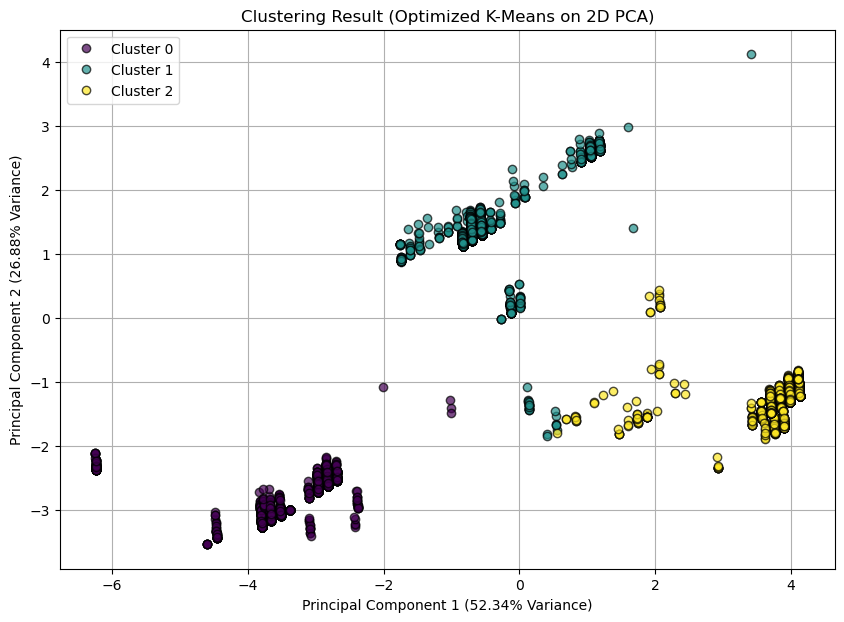

In [10]:
# Example for K-Means:
print("\n--- Analysis: Optimized K-Means ---")
if 'KMeans' in tuning_results_dfs:
    print("Top tuning results:")
    display(tuning_results_dfs['KMeans'].head())
    print("\nBest Optimized Parameters:")
    print(optimized_params_all['KMeans'])
    print(f"Best Optimized {PRIMARY_METRIC} Score: {optimized_scores_all['KMeans']['Score']:.4f}")

    # Compare to Part A
    part_a_kmeans_score = part_a_results_df[(part_a_results_df['Algorithm'] == 'K-Means') & (part_a_results_df['Dimensionality'] == f'{tuning_dimensionality_label} PCA')][PRIMARY_METRIC].iloc[0]
    print(f"Part A Score: {part_a_kmeans_score:.4f}")
    improvement = optimized_scores_all['KMeans']['Score'] - part_a_kmeans_score
    print(f"Improvement from Tuning: {improvement:+.4f}")

    # Plot final result
    plot_clusters_2d(X_tuning, optimized_labels_all['KMeans'], pca_2d, "Optimized K-Means")
    plt.show()

# 2. Mean Shift

In [11]:
# --- Mean Shift ---
# MeanShift tuning needs special handling for bandwidth estimation
print(f"\n--- Tuning MeanShift ({tuning_dimensionality_label} PCA) ---")
best_ms_score = -np.inf if HIGHER_IS_BETTER else np.inf
best_ms_params = {}
best_ms_labels = None
ms_run_results = []
ms_grid = list(ParameterGrid(param_grids['MeanShift'])) # Using 'quantile' here

for i, params in enumerate(ms_grid):
    print(f"  Running combination {i+1}/{len(ms_grid)}: {params}", end='\r')
    current_run_result = params.copy()
    try:
        # Estimate bandwidth using the quantile parameter
        bandwidth = estimate_bandwidth(X_tuning, quantile=params['quantile'], n_samples=min(1000, X_tuning.shape[0]))
        if bandwidth <= 0: # Bandwidth must be positive
             current_run_result['Error'] = "Estimated bandwidth <= 0"
             ms_run_results.append(current_run_result)
             continue

        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        labels = ms.fit_predict(X_tuning)
        n_clusters = len(np.unique(labels)) # MeanShift doesn't typically produce noise label -1

        current_run_result['bandwidth_estimated'] = bandwidth
        current_run_result['Num_Clusters'] = n_clusters

        if n_clusters >= 2:
            silhouette = silhouette_score(X_tuning, labels)
            davies_bouldin = davies_bouldin_score(X_tuning, labels)
            calinski_harabasz = calinski_harabasz_score(X_tuning, labels)
            current_run_result['Silhouette'] = silhouette
            current_run_result['Davies-Bouldin'] = davies_bouldin
            current_run_result['Calinski-Harabasz'] = calinski_harabasz
            current_score = current_run_result[PRIMARY_METRIC]

            is_better = (HIGHER_IS_BETTER and current_score > best_ms_score) or \
                        (not HIGHER_IS_BETTER and current_score < best_ms_score)
            if is_better:
                best_ms_score = current_score
                best_ms_params = {'quantile': params['quantile'], 'bandwidth_estimated': bandwidth}
                best_ms_labels = labels
        else:
             current_run_result['Error'] = "Less than 2 clusters found"

    except Exception as e:
        current_run_result['Error'] = str(e)
    ms_run_results.append(current_run_result)

print(f"\nFinished tuning MeanShift.")
ms_df = pd.DataFrame(ms_run_results).sort_values(by=PRIMARY_METRIC, ascending=(not HIGHER_IS_BETTER))
if best_ms_params:
    print(f"Best {PRIMARY_METRIC} score for MeanShift: {best_ms_score:.4f}")
    print(f"Best parameters (quantile for estimation): {best_ms_params}")
    optimized_params_all['MeanShift'] = best_ms_params
    optimized_scores_all['MeanShift'] = {'Score': best_ms_score}
    optimized_labels_all['MeanShift'] = best_ms_labels
    tuning_results_dfs['MeanShift'] = ms_df
else:
    print("Warning: No valid solution found for MeanShift.")



--- Tuning MeanShift (2D PCA) ---
  Running combination 4/4: {'quantile': 0.4}
Finished tuning MeanShift.
Best Silhouette score for MeanShift: 0.9083
Best parameters (quantile for estimation): {'quantile': 0.3, 'bandwidth_estimated': 2.1758558939301125}



--- Analysis: Optimized Mean Shift ---
Top tuning results:


,quantile,bandwidth_estimated,Num_Clusters,Silhouette,Davies-Bouldin,Calinski-Harabasz
2,0.3,2.175856,3,0.908286,0.145518,261069.125092
3,0.4,2.226588,3,0.908286,0.145518,261069.125092
1,0.2,1.058879,10,0.839938,0.387892,221648.029875
0,0.1,0.277267,25,0.771157,0.283753,218602.602570



Best Optimized Parameters (showing quantile used for bandwidth estimation):
{'quantile': 0.3, 'bandwidth_estimated': 2.1758558939301125}
Best Optimized Silhouette Score: 0.9083
Part A Score: 0.8069
Improvement from Tuning: +0.1014


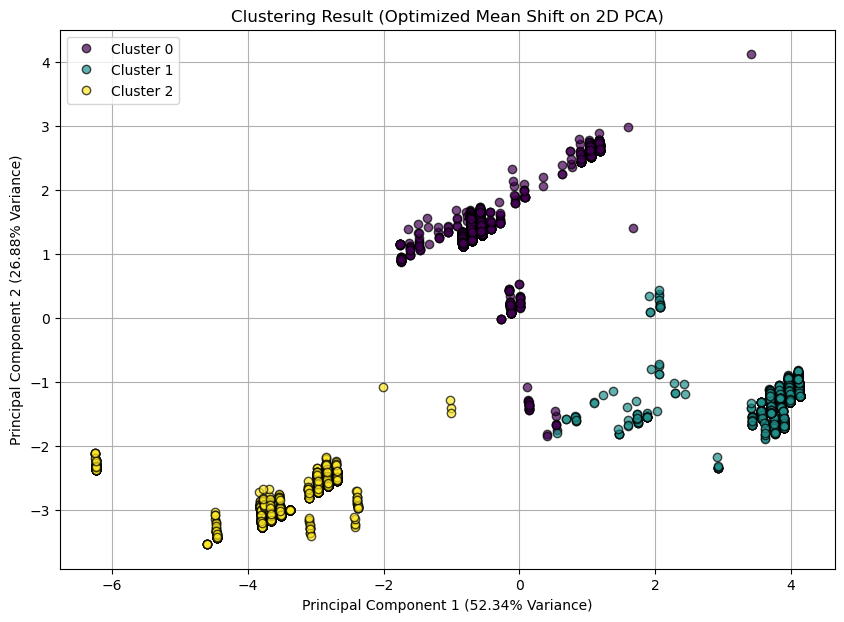

In [12]:
# --- Analysis: Optimized Mean Shift ---
print("\n--- Analysis: Optimized Mean Shift ---")
if 'MeanShift' in tuning_results_dfs:
    print("Top tuning results:")
    display(tuning_results_dfs['MeanShift'].head())
    print("\nBest Optimized Parameters (showing quantile used for bandwidth estimation):")
    print(optimized_params_all['MeanShift'])
    print(f"Best Optimized {PRIMARY_METRIC} Score: {optimized_scores_all['MeanShift']['Score']:.4f}")

    # Compare to Part A
    try:
        part_a_meanshift_score = part_a_results_df[(part_a_results_df['Algorithm'] == 'Mean Shift') & (part_a_results_df['Dimensionality'] == f'{tuning_dimensionality_label} PCA')][PRIMARY_METRIC].iloc[0] # Note space in 'Mean Shift' in Part A results
        print(f"Part A Score: {part_a_meanshift_score:.4f}")
        improvement = optimized_scores_all['MeanShift']['Score'] - part_a_meanshift_score
        print(f"Improvement from Tuning: {improvement:+.4f}")
    except IndexError:
        print("Could not find matching Part A score for Mean Shift.")

    # Plot final result
    if optimized_labels_all.get('MeanShift') is not None:
        plot_clusters_2d(X_tuning, optimized_labels_all['MeanShift'], pca_2d, "Optimized Mean Shift")
        plt.show()
    else:
        print("No optimized labels found for Mean Shift to plot.")

    # Add Markdown Explanation:
    # Discuss: How did tuning the quantile (affecting bandwidth) change the number of clusters and the score?
    # Compare the optimized plot (number/shape of clusters) to the Part A Mean Shift plot.
    # Explain why the resulting number of clusters/performance might be better or worse now.
    # ... (markdown cell here in notebook) ...
else:
    print("No tuning results found for MeanShift.")

# 3. Agglomerative Clustering

In [13]:
# --- Agglomerative Clustering ---
# Need to handle constraint: ward linkage requires euclidean metric
agg_grid = []
for params in ParameterGrid(param_grids['AgglomerativeClustering']):
    if params['linkage'] == 'ward' and params['metric'] != 'euclidean':
        continue # Skip invalid combinations
    agg_grid.append(params)

# Now tune using the filtered grid 'agg_grid' - requires slight modification
# Or, simplify: always use 'euclidean' as it's standard for PCA
agg_params, agg_score, agg_labels, agg_df = tune_clustering_model(
     AgglomerativeClustering,
     {'n_clusters': param_grids['AgglomerativeClustering']['n_clusters'],
      'linkage': param_grids['AgglomerativeClustering']['linkage'],
      'metric': ['euclidean']}, # Force euclidean
     X_tuning, "AgglomerativeClustering", tuning_dimensionality_label
)
if agg_params:
    optimized_params_all['AgglomerativeClustering'] = agg_params
    optimized_scores_all['AgglomerativeClustering'] = {'Score': agg_score}
    optimized_labels_all['AgglomerativeClustering'] = agg_labels
    tuning_results_dfs['AgglomerativeClustering'] = agg_df



--- Tuning AgglomerativeClustering (2D PCA) ---
Total combinations (21) <= threshold (60). Performing full grid search.
  Grid Search - Running combination 21/21: {'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 8}}
Finished tuning AgglomerativeClustering (Grid Search) in 193.81 seconds.
Best Silhouette score found for AgglomerativeClustering: 0.9077
Best parameters found: {'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 3}
Re-fitting AgglomerativeClustering with best parameters to ensure correct labels...



--- Analysis: Optimized Agglomerative Clustering ---
Top tuning results:


,linkage,metric,n_clusters,Silhouette,Davies-Bouldin,Calinski-Harabasz,Num_Clusters,Error
15,average,euclidean,3,0.907666,0.145852,254977.118546,3,None
1,ward,euclidean,3,0.907417,0.145842,251060.592845,3,None
16,average,euclidean,4,0.898462,0.123402,170735.157076,4,None
2,ward,euclidean,4,0.896581,0.127406,289080.828137,4,None
9,complete,euclidean,4,0.894558,0.153018,294691.380366,4,None



Best Optimized Parameters:
{'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 3}
Best Optimized Silhouette Score: 0.9077
Part A Score (Ward): 0.9074
Improvement from Tuning: +0.0002


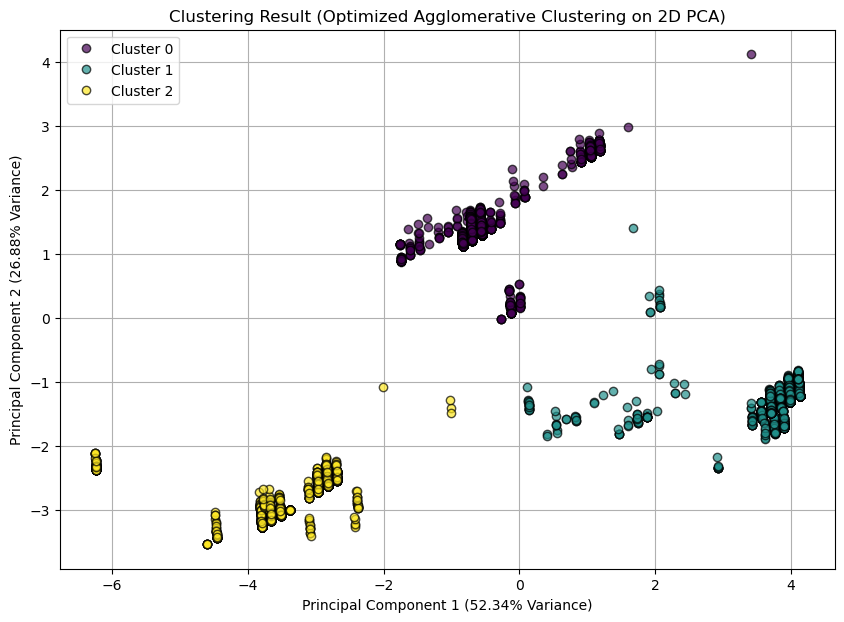

In [14]:
# --- Analysis: Optimized Agglomerative Clustering ---
print("\n--- Analysis: Optimized Agglomerative Clustering ---")
if 'AgglomerativeClustering' in tuning_results_dfs:
    print("Top tuning results:")
    display(tuning_results_dfs['AgglomerativeClustering'].head())
    print("\nBest Optimized Parameters:")
    print(optimized_params_all['AgglomerativeClustering'])
    print(f"Best Optimized {PRIMARY_METRIC} Score: {optimized_scores_all['AgglomerativeClustering']['Score']:.4f}")

    # Compare to Part A
    try:
        # Assuming Part A used 'Agglomerative (Ward)' name
        part_a_agg_score = part_a_results_df[(part_a_results_df['Algorithm'] == 'Agglomerative (Ward)') & (part_a_results_df['Dimensionality'] == f'{tuning_dimensionality_label} PCA')][PRIMARY_METRIC].iloc[0]
        print(f"Part A Score (Ward): {part_a_agg_score:.4f}")
        improvement = optimized_scores_all['AgglomerativeClustering']['Score'] - part_a_agg_score
        print(f"Improvement from Tuning: {improvement:+.4f}")
    except IndexError:
        print("Could not find matching Part A score for Agglomerative Clustering (Ward).")


    # Plot final result
    if optimized_labels_all.get('AgglomerativeClustering') is not None:
        plot_clusters_2d(X_tuning, optimized_labels_all['AgglomerativeClustering'], pca_2d, "Optimized Agglomerative Clustering")
        plt.show()
    else:
        print("No optimized labels found for Agglomerative Clustering to plot.")

    # Add Markdown Explanation:
    # Discuss: Which linkage method performed best? How did n_clusters influence the score?
    # Compare the visual result to Part A (which likely used Ward and k=3). Did other linkages/k perform better?
    # Explain why the chosen linkage/k might be optimal based on cluster shape/separation.
    # ... (markdown cell here in notebook) ...
else:
    print("No tuning results found for AgglomerativeClustering.")

# 4. DBSCAN

In [15]:
# --- DBSCAN ---
dbscan_params, dbscan_score, dbscan_labels, dbscan_df = tune_clustering_model(
    DBSCAN, param_grids['DBSCAN'], X_tuning, "DBSCAN", tuning_dimensionality_label
)
if dbscan_params:
    optimized_params_all['DBSCAN'] = dbscan_params
    optimized_scores_all['DBSCAN'] = {'Score': dbscan_score}
    optimized_labels_all['DBSCAN'] = dbscan_labels
    tuning_results_dfs['DBSCAN'] = dbscan_df


--- Tuning DBSCAN (2D PCA) ---
Total combinations (56) <= threshold (60). Performing full grid search.
  Grid Search - Running combination 56/56: {'eps': 0.6, 'min_samples': 12}}
Finished tuning DBSCAN (Grid Search) in 211.94 seconds.
Best Silhouette score found for DBSCAN: 0.8319
Best parameters found: {'eps': 0.25, 'min_samples': 12}
Re-fitting DBSCAN with best parameters to ensure correct labels...



--- Analysis: Optimized DBSCAN ---
Top tuning results:


,eps,min_samples,Silhouette,Davies-Bouldin,Calinski-Harabasz,Num_Clusters,Error
27,0.25,12,0.831874,0.273035,347265.347364,14,None
26,0.25,10,0.831813,0.281218,347202.756946,14,None
34,0.30,12,0.831619,0.281252,345677.430962,14,None
33,0.30,10,0.831619,0.281252,345677.430962,14,None
25,0.25,8,0.814115,0.274675,322148.165556,15,None



Best Optimized Parameters:
{'eps': 0.25, 'min_samples': 12}
Best Optimized Silhouette Score: 0.8319
Part A Score: 0.4226
Improvement from Tuning: +0.4093


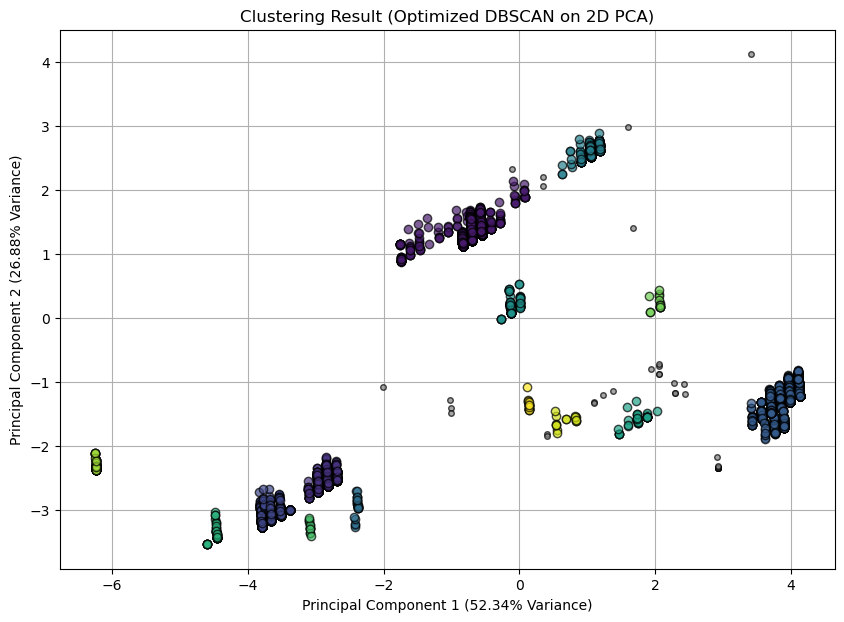

In [16]:
# --- Analysis: Optimized DBSCAN ---
print("\n--- Analysis: Optimized DBSCAN ---")
if 'DBSCAN' in tuning_results_dfs:
    print("Top tuning results:")
    display(tuning_results_dfs['DBSCAN'].head())
    print("\nBest Optimized Parameters:")
    print(optimized_params_all['DBSCAN'])
    print(f"Best Optimized {PRIMARY_METRIC} Score: {optimized_scores_all['DBSCAN']['Score']:.4f}")

    # Compare to Part A
    try:
        part_a_dbscan_score = part_a_results_df[(part_a_results_df['Algorithm'] == 'DBSCAN') & (part_a_results_df['Dimensionality'] == f'{tuning_dimensionality_label} PCA')][PRIMARY_METRIC].iloc[0]
        print(f"Part A Score: {part_a_dbscan_score:.4f}")
        improvement = optimized_scores_all['DBSCAN']['Score'] - part_a_dbscan_score
        print(f"Improvement from Tuning: {improvement:+.4f}")
    except IndexError:
        print("Could not find matching Part A score for DBSCAN.")


    # Plot final result
    if optimized_labels_all.get('DBSCAN') is not None:
        plot_clusters_2d(X_tuning, optimized_labels_all['DBSCAN'], pca_2d, "Optimized DBSCAN")
        plt.show()
    else:
        print("No optimized labels found for DBSCAN to plot.")

    # Add Markdown Explanation:
    # Discuss: How sensitive was the result to 'eps' and 'min_samples'? Which combination yielded the best balance?
    # Look at the number of clusters and noise points in the optimized version vs. Part A. Did tuning help find a more meaningful structure?
    # Explain the trade-off between 'eps' and 'min_samples' in defining density.
    # Compare the optimized plot visually - are clusters clearer? Less noise?
    # ... (markdown cell here in notebook) ...
else:
    print("No tuning results found for DBSCAN.")


# 5. Gaussian Mixture Model

In [17]:
# --- Gaussian Mixture ---
gmm_params, gmm_score, gmm_labels, gmm_df = tune_clustering_model(
    GaussianMixture, param_grids['GaussianMixture'], X_tuning, "GaussianMixture", tuning_dimensionality_label,
    random_state=42
)
if gmm_params:
    optimized_params_all['GaussianMixture'] = gmm_params
    optimized_scores_all['GaussianMixture'] = {'Score': gmm_score}
    optimized_labels_all['GaussianMixture'] = gmm_labels
    tuning_results_dfs['GaussianMixture'] = gmm_df


--- Tuning GaussianMixture (2D PCA) ---
Total combinations (56) <= threshold (60). Performing full grid search.
  Grid Search - Running combination 56/56: {'covariance_type': 'spherical', 'n_components': 8, 'n_init': 10}
Finished tuning GaussianMixture (Grid Search) in 236.73 seconds.
Best Silhouette score found for GaussianMixture: 0.9076
Best parameters found: {'covariance_type': 'tied', 'n_components': 3, 'n_init': 5}
Re-fitting GaussianMixture with best parameters to ensure correct labels...



--- Analysis: Optimized Gaussian Mixture ---
Top tuning results:


,covariance_type,n_components,n_init,Silhouette,Davies-Bouldin,Calinski-Harabasz,Num_Clusters,Error
16,tied,3,5,0.907566,0.147711,255053.402142,3,None
17,tied,3,10,0.907566,0.147711,255053.402142,3,None
45,spherical,3,10,0.902451,0.156748,207252.465346,3,None
44,spherical,3,5,0.902451,0.156748,207252.465346,3,None
31,diag,3,10,0.901301,0.158571,197774.971878,3,None



Best Optimized Parameters:
{'covariance_type': 'tied', 'n_components': 3, 'n_init': 5}
Best Optimized Silhouette Score: 0.9076
Part A Score: 0.8744
Improvement from Tuning: +0.0332


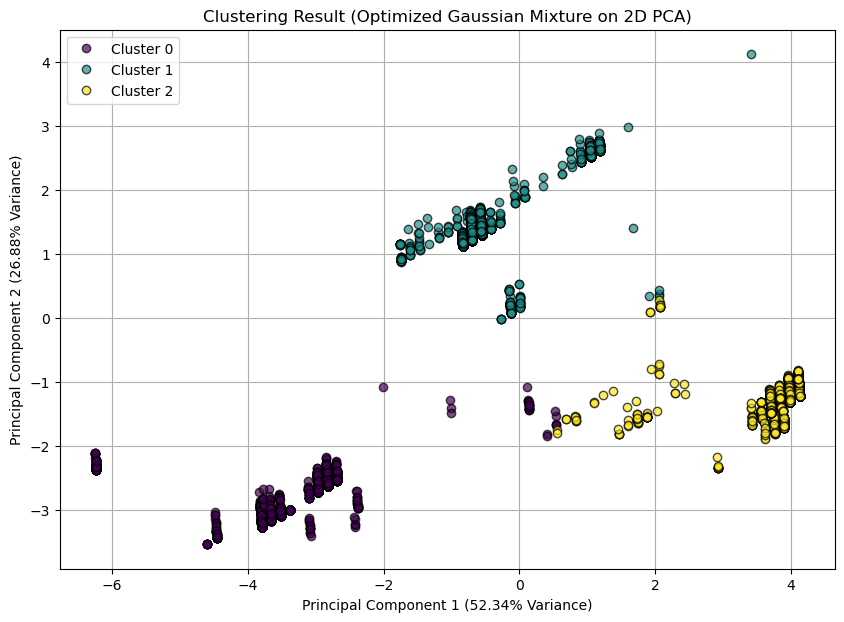

In [18]:
# --- Analysis: Optimized Gaussian Mixture ---
print("\n--- Analysis: Optimized Gaussian Mixture ---")
if 'GaussianMixture' in tuning_results_dfs:
    print("Top tuning results:")
    display(tuning_results_dfs['GaussianMixture'].head())
    print("\nBest Optimized Parameters:")
    print(optimized_params_all['GaussianMixture'])
    print(f"Best Optimized {PRIMARY_METRIC} Score: {optimized_scores_all['GaussianMixture']['Score']:.4f}")

    # Compare to Part A
    try:
        part_a_gmm_score = part_a_results_df[(part_a_results_df['Algorithm'] == 'GMM') & (part_a_results_df['Dimensionality'] == f'{tuning_dimensionality_label} PCA')][PRIMARY_METRIC].iloc[0]
        print(f"Part A Score: {part_a_gmm_score:.4f}")
        improvement = optimized_scores_all['GaussianMixture']['Score'] - part_a_gmm_score
        print(f"Improvement from Tuning: {improvement:+.4f}")
    except IndexError:
        print("Could not find matching Part A score for GMM.")

    # Plot final result
    if optimized_labels_all.get('GaussianMixture') is not None:
        plot_clusters_2d(X_tuning, optimized_labels_all['GaussianMixture'], pca_2d, "Optimized Gaussian Mixture")
        plt.show()
    else:
        print("No optimized labels found for Gaussian Mixture to plot.")

    # Add Markdown Explanation:
    # Discuss: Which 'covariance_type' worked best? Why might that be (e.g., spherical clusters vs. elliptical)?
    # How did the optimal 'n_components' compare to the BIC/AIC result from Part A?
    # Analyze the visual plot - does it look better than the Part A GMM plot? Does the number of components seem appropriate?
    # ... (markdown cell here in notebook) ...
else:
    print("No tuning results found for GaussianMixture.")

# 6. HDBSCAN

In [19]:
# Cell: Tune HDBSCAN (if available and grid defined)

# --- HDBSCAN (Using the tuning function) ---
print("\n" + "="*20 + " Tuning HDBSCAN " + "="*20)

# Double-check availability and grid definition before calling
if hdbscan_available and "HDBSCAN" in param_grids:
    hdb_params, hdb_score, hdb_labels, hdb_df = tune_clustering_model(
        hdbscan.HDBSCAN,                            # Pass the model class
        param_grids['HDBSCAN'],                     # Pass the parameter grid
        X_tuning,                                   # Pass the data
        "HDBSCAN",                                  # Pass the model name string
        tuning_dimensionality_label,                # Pass the dimensionality label
        # **kwargs for HDBSCAN specific arguments if needed:
        allow_single_cluster=True,                  # Example: Often useful for HDBSCAN
        # core_dist_n_jobs=-1                     # Example: Use all CPU cores if needed
    )

    # Store results (only if tuning was successful)
    if hdb_params is not None:
        optimized_params_all['HDBSCAN'] = hdb_params
        optimized_scores_all['HDBSCAN'] = {'Score': hdb_score} # Store primary score
        optimized_labels_all['HDBSCAN'] = hdb_labels
        tuning_results_dfs['HDBSCAN'] = hdb_df
        print(f"Successfully stored tuning results for HDBSCAN.")
    else:
        # Handle tuning failure case
        optimized_params_all['HDBSCAN'] = None
        optimized_scores_all['HDBSCAN'] = None
        optimized_labels_all['HDBSCAN'] = None
        tuning_results_dfs['HDBSCAN'] = pd.DataFrame()
        print("HDBSCAN tuning did not find a valid solution or failed. Storing None.")

elif not hdbscan_available:
    print("Skipping HDBSCAN tuning: Library not available.")
else: # Grid not defined for some reason
     print("Skipping HDBSCAN tuning: Parameter grid not found in param_grids.")


==================== Tuning HDBSCAN ====================

--- Tuning HDBSCAN (2D PCA) ---
Total combinations (100) > threshold (60). Performing randomized search with 50 iterations.
  Randomized Sampling - Running combination 50/50: {'cluster_selection_epsilon': 0.5, 'min_cluster_size': 30, 'min_samples': 15}e}
Finished tuning HDBSCAN (Randomized Sampling) in 266.43 seconds.
Best Silhouette score found for HDBSCAN: 0.8168
Best parameters found: {'cluster_selection_epsilon': 0.5, 'min_cluster_size': 30, 'min_samples': None}
Re-fitting HDBSCAN with best parameters to ensure correct labels...
Successfully stored tuning results for HDBSCAN.



==================== Analysis: Optimized HDBSCAN ====================
Top tuning results:


,cluster_selection_epsilon,min_cluster_size,min_samples,Silhouette,Davies-Bouldin,Calinski-Harabasz,Num_Clusters,Error
42,0.5,30,NaN,0.816827,0.299410,309697.377562,8,None
49,0.5,30,15.0,0.750133,0.285733,113532.587729,8,None
2,0.5,5,15.0,0.750133,0.285733,113532.587729,8,None
9,0.5,15,15.0,0.750133,0.285733,113532.587729,8,None
23,0.5,10,15.0,0.750133,0.285733,113532.587729,8,None



Best Optimized Parameters found:
{'cluster_selection_epsilon': 0.5, 'min_cluster_size': 30, 'min_samples': None}
Best Optimized Silhouette Score (during tuning): 0.8168
Part A Score: 0.6748
Improvement from Tuning: +0.1420

Plotting optimized HDBSCAN result:


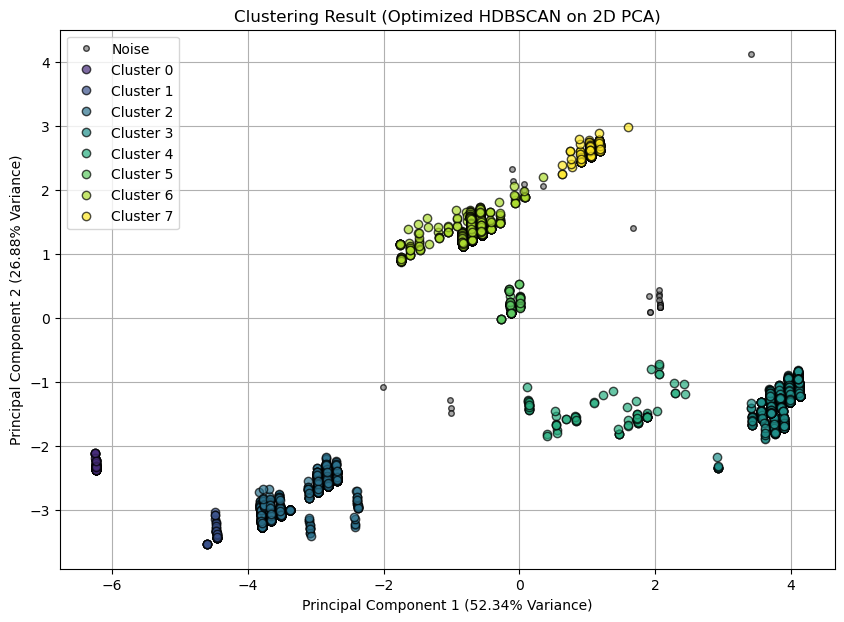

In [20]:
# Cell: Analysis of Optimized HDBSCAN Results

# --- Analysis: Optimized HDBSCAN ---
print("\n" + "="*20 + " Analysis: Optimized HDBSCAN " + "="*20)

# Check if tuning results exist and were successful
if hdbscan_available and 'HDBSCAN' in tuning_results_dfs and not tuning_results_dfs['HDBSCAN'].empty:
    print("Top tuning results:")
    display(tuning_results_dfs['HDBSCAN'].head()) # Show how params affected score

    print("\nBest Optimized Parameters found:")
    print(optimized_params_all.get('HDBSCAN', "N/A"))

    best_tuning_score = optimized_scores_all.get('HDBSCAN', {}).get('Score', None)
    if best_tuning_score is not None:
         print(f"Best Optimized {PRIMARY_METRIC} Score (during tuning): {best_tuning_score:.4f}")
    else:
         print(f"Best Optimized {PRIMARY_METRIC} Score (during tuning): N/A")

    # Compare to Part A score
    try:
        part_a_hdbscan_score = part_a_results_df[
            (part_a_results_df['Algorithm'] == 'HDBSCAN') &
            (part_a_results_df['Dimensionality'] == f'{tuning_dimensionality_label} PCA')
        ][PRIMARY_METRIC].iloc[0]
        print(f"Part A Score: {part_a_hdbscan_score:.4f}")
        if best_tuning_score is not None:
            improvement = best_tuning_score - part_a_hdbscan_score
            print(f"Improvement from Tuning: {improvement:+.4f}")
        else:
            print("Cannot calculate improvement as optimized score is missing.")
    except (IndexError, TypeError, KeyError):
        print("Could not find or compare with matching Part A score for HDBSCAN.")

    # Plot final result using the labels obtained from the best parameters
    final_labels = optimized_labels_all.get('HDBSCAN')
    if final_labels is not None:
        print("\nPlotting optimized HDBSCAN result:")
        if tuning_dimensionality_label == "2D":
            plot_clusters_2d(X_tuning, final_labels, pca_2d, "Optimized HDBSCAN")
        else:
            plot_clusters_3d(X_tuning, final_labels, pca_3d, "Optimized HDBSCAN")
        plt.show()
    else:
        print("\nNo optimized labels found for HDBSCAN to plot.")

    # --- Add Markdown Explanation Cell Below ---
    # Discuss:
    # 1. How did changing `min_cluster_size` affect the granularity and number of clusters?
    # 2. How did `min_samples` (which influences the core distance/mutual reachability) impact cluster stability and noise points? What does setting it to None achieve?
    # 3. Did tuning `cluster_selection_epsilon` make a difference in merging clusters or reducing noise?
    # 4. Explain HDBSCAN's core idea (density-based hierarchy, cluster stability) and how these parameters control that process.
    # 5. Compare the optimized plot visually to the Part A plot. Did tuning help significantly reduce the fragmentation seen previously? Does it now reveal a more interpretable structure? How many clusters/noise points are present?
    # 6. Discuss the final score compared to Part A and other optimized models. Did HDBSCAN become more competitive after tuning?

elif not hdbscan_available:
    print("HDBSCAN analysis skipped: Library not available.")
else:
    print("No tuning results found or tuning failed/skipped for HDBSCAN.")

In [21]:
# --- HDBSCAN (if available) ---
#if hdbscan_available:
#    hdb_params, hdb_score, hdb_labels, hdb_df = tune_clustering_model(
#        hdbscan.HDBSCAN, param_grids['HDBSCAN'], X_tuning, "HDBSCAN", tuning_dimensionality_label,
#        # HDBSCAN specific arguments if needed, e.g.:
#        # core_dist_n_jobs=-1 # Use all cores
#    )
#    if hdb_params:
#        optimized_params_all['HDBSCAN'] = hdb_params
#        optimized_scores_all['HDBSCAN'] = {'Score': hdb_score}
#        optimized_labels_all['HDBSCAN'] = hdb_labels
#        tuning_results_dfs['HDBSCAN'] = hdb_df

# Add tuning for BIRCH here if it becomes available

#print("\n--- Completed Tuning for All Models ---")


In [22]:
# --- Analysis: Optimized HDBSCAN ---
#print("\n--- Analysis: Optimized HDBSCAN ---")
#if hdbscan_available and 'HDBSCAN' in tuning_results_dfs:
#    print("Top tuning results:")
#    display(tuning_results_dfs['HDBSCAN'].head())
#    print("\nBest Optimized Parameters:")
#    print(optimized_params_all['HDBSCAN'])
#    print(f"Best Optimized {PRIMARY_METRIC} Score: {optimized_scores_all['HDBSCAN']['Score']:.4f}")

    # Compare to Part A
#    try:
#        part_a_hdbscan_score = part_a_results_df[(part_a_results_df['Algorithm'] == 'HDBSCAN') & (part_a_results_df['Dimensionality'] == f'{tuning_dimensionality_label} PCA')][PRIMARY_METRIC].iloc[0]
#        print(f"Part A Score: {part_a_hdbscan_score:.4f}")
#        improvement = optimized_scores_all['HDBSCAN']['Score'] - part_a_hdbscan_score
#        print(f"Improvement from Tuning: {improvement:+.4f}")
#    except IndexError:
#        print("Could not find matching Part A score for HDBSCAN.")


    # Plot final result
#    if optimized_labels_all.get('HDBSCAN') is not None:
#        plot_clusters_2d(X_tuning, optimized_labels_all['HDBSCAN'], pca_2d, "Optimized HDBSCAN")
#        plt.show()
#    else:
#        print("No optimized labels found for HDBSCAN to plot.")

    # Add Markdown Explanation:
    # Discuss: How did 'min_cluster_size' and 'min_samples' affect the number of clusters found and the amount of noise?
    # Did tuning 'cluster_selection_epsilon' have a noticeable effect?
    # Compare the optimized plot to the Part A HDBSCAN plot - did tuning significantly reduce the fragmentation? Does it reveal a more meaningful structure?
    # Explain the role of these parameters in controlling the cluster hierarchy extraction.
    # ... (markdown cell here in notebook) ...
#elif not hdbscan_available:
#    print("HDBSCAN not available.")
#else:
#    print("No tuning results found for HDBSCAN.")

# 7. BIRCH

In [23]:
# --- Analysis: Optimized BIRCH ---
print("\n--- Analysis: Optimized BIRCH ---")

# Attempt to import BIRCH here to be certain before calling tune
try:
    from sklearn.cluster import Birch
    birch_available_runtime = True
except ImportError:
    birch_available_runtime = False
    print("BIRCH class could not be imported. Skipping tuning.")

if birch_available_runtime and "BIRCH" in param_grids:
    # Note: BIRCH's n_clusters can interfere with its internal logic based on threshold/branching factor.
    # Consider setting n_clusters=None in the grid if you want BIRCH to determine clusters based on its structure.
    # However, for comparison, we often set it like K-Means.

    birch_params, birch_score, birch_labels, birch_df = tune_clustering_model(
        Birch,                                      # Pass the model class
        param_grids['BIRCH'],                       # Pass the parameter grid
        X_tuning,                                   # Pass the data
        "BIRCH",                                    # Pass the model name string
        tuning_dimensionality_label,                # Pass the dimensionality label
        # No specific fixed kwargs needed typically for BIRCH
    )

    # Store results (only if tuning was successful)
    if birch_params is not None:
        optimized_params_all['BIRCH'] = birch_params
        optimized_scores_all['BIRCH'] = {'Score': birch_score}
        optimized_labels_all['BIRCH'] = birch_labels
        tuning_results_dfs['BIRCH'] = birch_df
        print(f"Successfully stored tuning results for BIRCH.")
    else:
        optimized_params_all['BIRCH'] = None
        optimized_scores_all['BIRCH'] = None
        optimized_labels_all['BIRCH'] = None
        tuning_results_dfs['BIRCH'] = pd.DataFrame()
        print("BIRCH tuning did not find a valid solution or failed. Storing None.")
else:
    if "BIRCH" in param_grids: # Check if grid exists even if import failed
         print("Skipping BIRCH tuning: Class available but grid might be missing or other issue.")
    # If the class wasn't imported, the message is printed above.


--- Analysis: Optimized BIRCH ---

--- Tuning BIRCH (2D PCA) ---
Total combinations (63) > threshold (60). Performing randomized search with 50 iterations.
  Randomized Sampling - Running combination 50/50: {'branching_factor': 40, 'n_clusters': 8, 'threshold': 0.5}
Finished tuning BIRCH (Randomized Sampling) in 188.40 seconds.
Best Silhouette score found for BIRCH: 0.9082
Best parameters found: {'branching_factor': 60, 'n_clusters': 3, 'threshold': 0.7}
Re-fitting BIRCH with best parameters to ensure correct labels...
Successfully stored tuning results for BIRCH.



==================== Analysis: Optimized BIRCH ====================
Top tuning results:


,branching_factor,n_clusters,threshold,Silhouette,Davies-Bouldin,Calinski-Harabasz,Num_Clusters,Error
28,40,3,0.7,0.908231,0.145551,260838.972286,3,None
17,60,3,0.7,0.908231,0.145551,260838.972286,3,None
0,40,3,0.5,0.908228,0.145627,260742.567901,3,None
41,60,3,0.5,0.908228,0.145627,260742.567901,3,None
22,50,3,0.5,0.908228,0.145627,260742.567901,3,None



Best Optimized Parameters found:
{'branching_factor': 60, 'n_clusters': 3, 'threshold': 0.7}
Best Optimized Silhouette Score (during tuning): 0.9082
Part A Score: 0.9082
Improvement from Tuning: +0.0000

Plotting optimized BIRCH result:


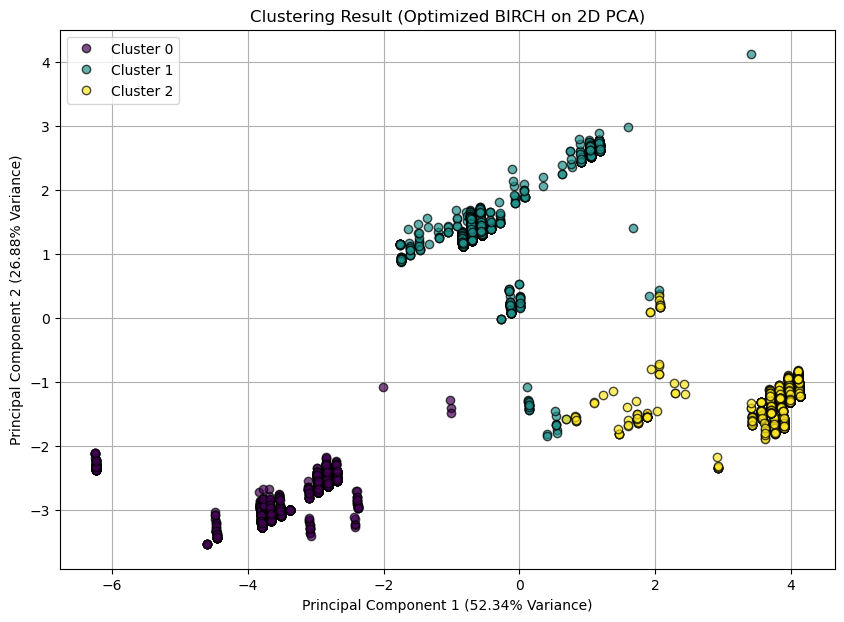

In [24]:
# Cell: Analysis of Optimized BIRCH Results

# --- Analysis: Optimized BIRCH ---
print("\n" + "="*20 + " Analysis: Optimized BIRCH " + "="*20)

# Check if tuning results exist and were successful
if 'BIRCH' in tuning_results_dfs and not tuning_results_dfs['BIRCH'].empty:
    print("Top tuning results:")
    display(tuning_results_dfs['BIRCH'].head()) # Show how params affected score

    print("\nBest Optimized Parameters found:")
    print(optimized_params_all.get('BIRCH', "N/A"))

    best_tuning_score = optimized_scores_all.get('BIRCH', {}).get('Score', None)
    if best_tuning_score is not None:
         print(f"Best Optimized {PRIMARY_METRIC} Score (during tuning): {best_tuning_score:.4f}")
    else:
         print(f"Best Optimized {PRIMARY_METRIC} Score (during tuning): N/A")

    # Compare to Part A score
    try:
        # Ensure the algorithm name matches exactly how it appears in your Part A results DataFrame
        part_a_birch_score = part_a_results_df[
            (part_a_results_df['Algorithm'] == 'BIRCH') &
            (part_a_results_df['Dimensionality'] == f'{tuning_dimensionality_label} PCA')
        ][PRIMARY_METRIC].iloc[0]
        print(f"Part A Score: {part_a_birch_score:.4f}")
        if best_tuning_score is not None:
            improvement = best_tuning_score - part_a_birch_score
            print(f"Improvement from Tuning: {improvement:+.4f}")
        else:
            print("Cannot calculate improvement as optimized score is missing.")
    except (IndexError, TypeError, KeyError):
        print("Could not find or compare with matching Part A score for BIRCH.")

    # Plot final result using the labels obtained from the best parameters
    final_labels = optimized_labels_all.get('BIRCH')
    if final_labels is not None:
        print("\nPlotting optimized BIRCH result:")
        if tuning_dimensionality_label == "2D":
            plot_clusters_2d(X_tuning, final_labels, pca_2d, "Optimized BIRCH")
        else:
            plot_clusters_3d(X_tuning, final_labels, pca_3d, "Optimized BIRCH")
        plt.show()
    else:
        print("\nNo optimized labels found for BIRCH to plot.")

    # --- Add Markdown Explanation Cell Below ---
    # Discuss:
    # 1. How did the `threshold` parameter influence the results? A higher threshold generally leads to fewer subclusters in the CF-tree.
    # 2. How did the `branching_factor` affect performance or potentially runtime? It controls the size of nodes in the CF-tree.
    # 3. How did the optimal `n_clusters` compare to Part A and other models?
    # 4. Explain BIRCH's core idea (CF-tree for summarizing data) and why it's memory-efficient. How might `threshold` and `branching_factor` relate to the identified clusters?
    # 5. Compare the optimized plot to the Part A plot.
    # 6. Discuss the final optimized score relative to Part A and other tuned models.
    #
    # Example Markdown Text:
    # "BIRCH tuning explored `n_clusters`, `threshold`, and `branching_factor`. The best Silhouette score ([best_score]) was achieved with parameters [best_params].
    # The optimal `threshold` of [best_threshold] suggests [interpretation]. Changes in `branching_factor` had [minor/significant] impact.
    # The number of clusters found/specified as optimal was [best_n_clusters].
    # Visually, the optimized BIRCH result [describe plot changes]. Compared to Part A, tuning yielded an improvement of [improvement value], ranking it [rank] overall."

else:
    print("No tuning results found or tuning failed/skipped for BIRCH.")